In [1]:
%matplotlib inline
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import pickle
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import regularizers
import pathlib
from tensorflow.keras.models import load_model
from tensorflow import keras
import itertools
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
import tensorflow as tf

d:\programdata\anaconda3\envs\zhy\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\programdata\anaconda3\envs\zhy\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\programdata\anaconda3\envs\zhy\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
d:\programdata\anaconda3\envs\zhy\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %
d:\programdata\anaconda3\envs\zhy\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you w

In [2]:
fileDirCASIA = pathlib.Path(r'D:\jupyter\EMO-DB')

In [3]:
def normalizeVoiceLen(y,normalizedLen):
    nframes=len(y)
    y = np.reshape(y,[nframes,1]).T
    
    #归一化音频长度为2s,32000数据点
    if(nframes<normalizedLen):
        res=normalizedLen-nframes
        res_data=np.zeros([1,res],dtype=np.float32)
        y = np.reshape(y,[nframes,1]).T
        y=np.c_[y,res_data]
    else:
        y=y[:,0:normalizedLen]
    return y[0]


In [4]:
def getNearestLen(framelength,sr):
    framesize = framelength*sr  
    #找到与当前framesize最接近的2的正整数次方
    nfftdict = {}
    lists = [32,64,128,256,512,1024]
    for i in lists:
        nfftdict[i] = abs(framesize - i)
    sortlist = sorted(nfftdict.items(), key=lambda x: x[1])#按与当前framesize差值升序排列
    framesize = int(sortlist[0][0])#取最接近当前framesize的那个2的正整数次方值为新的framesize
    return framesize


In [5]:
mfccs={}
mfccs['anger']=[]
mfccs['boredom']=[]
mfccs['disgust']=[]
mfccs['fear']=[]
mfccs['happiness']=[]
mfccs['neutral']=[]
mfccs['sadness']=[]

In [6]:
speaker={}
speaker['anger']=[]
speaker['boredom']=[]
speaker['disgust']=[]
speaker['fear']=[]
speaker['happiness']=[]
speaker['neutral']=[]
speaker['sadness']=[]

In [7]:
#files=os.listdir(fileDirCASIA)
counter=0
listdir=os.listdir(fileDirCASIA)
for persondir in listdir:
    if(not r'.' in persondir):
        emotionDirName=os.path.join(fileDirCASIA,persondir)
        emotiondir=os.listdir(emotionDirName)
        for ed in emotiondir:
            if(not r'.' in ed):
                filesDirName=os.path.join(emotionDirName,ed)
                files=os.listdir(filesDirName)
                for fileName in files:
                    if(fileName[-3:]=='wav'):
                        counter+=1
                        fn=os.path.join(filesDirName,fileName)
                        print(str(counter)+fn)
                        y,sr = librosa.load(fn,sr=None)
                        y=normalizeVoiceLen(y,32000)#归一化长度
                        N_FFT=getNearestLen(0.25,sr)                    
                        
                        stft = np.abs(librosa.stft(y))
                        
                        pitches, magnitudes = librosa.piptrack(y, sr=sr, S=stft, fmin=70, fmax=400) #音高，振幅
                        # fmin 和 fmax 对应于人类语音的最小最大基本频率
                        pitch = []
                        for i in range(magnitudes.shape[1]):
                            index = magnitudes[:, 1].argmax()
                            pitch.append(pitches[index, i])
                        
                        pitch_tuning_offset = librosa.pitch_tuning(pitches) #pitch_tuning()给定一个集合,估计其调谐偏移
                        pitchmean = np.mean(pitch)   #统计特征
                        pitchstd = np.std(pitch)  #计算标准差
                        pitchmax = np.max(pitch)
                        pitchmin = np.min(pitch) 
                        
                        cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                        cent = cent / np.sum(cent)
                        meancent = np.mean(cent)
                        stdcent = np.std(cent)  #标准差
                        maxcent = np.max(cent)
                        
                        # 谱平面
                        flatness = np.mean(librosa.feature.spectral_flatness(y=y))   #spectral_flatness频谱平坦度
                        
                        zerocr = np.mean(librosa.feature.zero_crossing_rate(y))
                        
                        S, phase = librosa.magphase(stft)  #计算复数图谱的幅度值和相位值
                        meanMagnitude = np.mean(S)
                        stdMagnitude = np.std(S)
                        maxMagnitude = np.max(S)
                        
#                         rmse = librosa.feature.rms(S=S)[0]  # 均方根能量
#                         meanrms = np.mean(rmse)
#                         stdrms = np.std(rmse)
#                         maxrms = np.max(rmse)
                        
                        ext_features = np.array([
                            flatness, zerocr, meanMagnitude, maxMagnitude, meancent, stdcent,
                            maxcent, stdMagnitude, pitchmean, pitchmax, pitchstd,
                            pitch_tuning_offset, 
                        ])   #数组
         
                        mfccmean = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)
                        mfccsstd=np.std(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)
                        mfccmax= np.max(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)
                         
                        # 色谱图
                        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0) 
                        #从stft的结果计算色谱图

                        # 梅尔频率
                        mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
                        
                        # ottava对比 谱对比度
                        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
                        
                        
                        feature = np.concatenate((ext_features, mfccmean ,mfccsstd, mfccmax, chroma, mel, contrast))
                        #feature=np.max(mfcc_data,axis=0)
                      
                        mfccs[ed].append(feature.tolist()) #将数组或矩阵转为列表
                        speaker[ed].append(fileName[0:2])


1D:\jupyter\EMO-DB\EMODB\anger\03a01Wa.wav
2D:\jupyter\EMO-DB\EMODB\anger\03a02Wb.wav
3D:\jupyter\EMO-DB\EMODB\anger\03a02Wc.wav
4D:\jupyter\EMO-DB\EMODB\anger\03a04Wc.wav
5D:\jupyter\EMO-DB\EMODB\anger\03a05Wa.wav
6D:\jupyter\EMO-DB\EMODB\anger\03a05Wb.wav
7D:\jupyter\EMO-DB\EMODB\anger\03a07Wc.wav
8D:\jupyter\EMO-DB\EMODB\anger\03b01Wa.wav
9D:\jupyter\EMO-DB\EMODB\anger\03b01Wc.wav
10D:\jupyter\EMO-DB\EMODB\anger\03b02Wb.wav
11D:\jupyter\EMO-DB\EMODB\anger\03b03Wc.wav
12D:\jupyter\EMO-DB\EMODB\anger\03b09Wa.wav
13D:\jupyter\EMO-DB\EMODB\anger\03b10Wb.wav
14D:\jupyter\EMO-DB\EMODB\anger\03b10Wc.wav
15D:\jupyter\EMO-DB\EMODB\anger\08a01Wa.wav
16D:\jupyter\EMO-DB\EMODB\anger\08a01Wc.wav
17D:\jupyter\EMO-DB\EMODB\anger\08a02Wc.wav
18D:\jupyter\EMO-DB\EMODB\anger\08a04Wc.wav
19D:\jupyter\EMO-DB\EMODB\anger\08a05Wa.wav
20D:\jupyter\EMO-DB\EMODB\anger\08a07Wc.wav
21D:\jupyter\EMO-DB\EMODB\anger\08b01Wa.wav
22D:\jupyter\EMO-DB\EMODB\anger\08b02Wd.wav
23D:\jupyter\EMO-DB\EMODB\anger\08b03Wd.w

185D:\jupyter\EMO-DB\EMODB\boredom\14b10Lb.wav
186D:\jupyter\EMO-DB\EMODB\boredom\15a01La.wav
187D:\jupyter\EMO-DB\EMODB\boredom\15a02La.wav
188D:\jupyter\EMO-DB\EMODB\boredom\15a05Lb.wav
189D:\jupyter\EMO-DB\EMODB\boredom\15a07Ld.wav
190D:\jupyter\EMO-DB\EMODB\boredom\15b01Lb.wav
191D:\jupyter\EMO-DB\EMODB\boredom\15b02Lb.wav
192D:\jupyter\EMO-DB\EMODB\boredom\15b03Lc.wav
193D:\jupyter\EMO-DB\EMODB\boredom\15b09La.wav
194D:\jupyter\EMO-DB\EMODB\boredom\15b10Lc.wav
195D:\jupyter\EMO-DB\EMODB\boredom\16a01Lb.wav
196D:\jupyter\EMO-DB\EMODB\boredom\16a02Lb.wav
197D:\jupyter\EMO-DB\EMODB\boredom\16a04La.wav
198D:\jupyter\EMO-DB\EMODB\boredom\16a04Lc.wav
199D:\jupyter\EMO-DB\EMODB\boredom\16a05La.wav
200D:\jupyter\EMO-DB\EMODB\boredom\16a07La.wav
201D:\jupyter\EMO-DB\EMODB\boredom\16a07Lb.wav
202D:\jupyter\EMO-DB\EMODB\boredom\16b01La.wav
203D:\jupyter\EMO-DB\EMODB\boredom\16b01Lc.wav
204D:\jupyter\EMO-DB\EMODB\boredom\16b02Lb.wav
205D:\jupyter\EMO-DB\EMODB\boredom\16b03La.wav
206D:\jupyter

366D:\jupyter\EMO-DB\EMODB\happiness\13b03Fd.wav
367D:\jupyter\EMO-DB\EMODB\happiness\13b09Fb.wav
368D:\jupyter\EMO-DB\EMODB\happiness\13b09Fc.wav
369D:\jupyter\EMO-DB\EMODB\happiness\13b10Fa.wav
370D:\jupyter\EMO-DB\EMODB\happiness\14a02Fd.wav
371D:\jupyter\EMO-DB\EMODB\happiness\14a05Fa.wav
372D:\jupyter\EMO-DB\EMODB\happiness\14a05Fb.wav
373D:\jupyter\EMO-DB\EMODB\happiness\14a07Fd.wav
374D:\jupyter\EMO-DB\EMODB\happiness\14b01Fa.wav
375D:\jupyter\EMO-DB\EMODB\happiness\14b01Fc.wav
376D:\jupyter\EMO-DB\EMODB\happiness\14b02Fb.wav
377D:\jupyter\EMO-DB\EMODB\happiness\14b09Fc.wav
378D:\jupyter\EMO-DB\EMODB\happiness\15a01Fb.wav
379D:\jupyter\EMO-DB\EMODB\happiness\15a04Fd.wav
380D:\jupyter\EMO-DB\EMODB\happiness\15a05Fb.wav
381D:\jupyter\EMO-DB\EMODB\happiness\15a07Fa.wav
382D:\jupyter\EMO-DB\EMODB\happiness\15a07Fb.wav
383D:\jupyter\EMO-DB\EMODB\happiness\15b09Fa.wav
384D:\jupyter\EMO-DB\EMODB\happiness\16a01Fc.wav
385D:\jupyter\EMO-DB\EMODB\happiness\16a04Fa.wav
386D:\jupyter\EMO-DB

In [8]:
with open('mfcc_feature_dict.pkl', 'wb') as f:
    pickle.dump(mfccs, f)

In [9]:
mfccs={}
with open('mfcc_feature_dict.pkl', 'rb') as f:
    mfccs=pickle.load(f)

#设置标签
emotionDict={}
emotionDict['anger']=0
emotionDict['boredom']=1
emotionDict['disgust']=2
emotionDict['fear']=3
emotionDict['happiness']=4
emotionDict['neutral']=5
emotionDict['sadness']=6
emotionDict


{'anger': 0,
 'boredom': 1,
 'disgust': 2,
 'fear': 3,
 'happiness': 4,
 'neutral': 5,
 'sadness': 6}

In [10]:
data_train=[]
labels_train=[]
data_val=[]
labels_val=[]
speaker_train=[]
speaker_val=[]
from sklearn.model_selection import train_test_split, GridSearchCV

In [11]:
x_train, x_test,y_train,y_test = train_test_split(mfccs['anger'],speaker['anger'],test_size=0.2)
data_train=data_train+x_train
data_val=data_val+x_test
speaker_train=speaker_train+y_train
speaker_val=speaker_val+y_test
print(len(x_train))
for i in range(len(x_train)):
    labels_train.append(0)
for i in range(len(x_test)):
    labels_val.append(0)
print(len(labels_train))
print(len(labels_val))

101
101
26


In [12]:
x_train, x_test,y_train,y_test = train_test_split(mfccs['boredom'],speaker['boredom'],test_size=0.2)
data_train=data_train+x_train
data_val=data_val+x_test
speaker_train=speaker_train+y_train
speaker_val=speaker_val+y_test
print(len(x_train))
for i in range(len(x_train)):
    labels_train.append(1)
for i in range(len(x_test)):
    labels_val.append(1)
print(len(labels_train))
print(len(labels_val))

64
165
43


In [13]:
x_train, x_test,y_train,y_test = train_test_split(mfccs['disgust'],speaker['disgust'], test_size=0.2)
data_train=data_train+x_train
data_val=data_val+x_test
speaker_train=speaker_train+y_train
speaker_val=speaker_val+y_test
print(len(x_train))
for i in range(len(x_train)):
    labels_train.append(2)
for i in range(len(x_test)):
    labels_val.append(2)
print(len(labels_train))
print(len(labels_val))

36
201
53


In [14]:
x_train, x_test,y_train,y_test = train_test_split(mfccs['fear'],speaker['fear'], test_size=0.2)
data_train=data_train+x_train
data_val=data_val+x_test
speaker_train=speaker_train+y_train
speaker_val=speaker_val+y_test
print(len(x_train))
for i in range(len(x_train)):
    labels_train.append(3)
for i in range(len(x_test)):
    labels_val.append(3)
print(len(labels_train))
print(len(labels_val))


55
256
67


In [15]:
x_train, x_test,y_train,y_test = train_test_split(mfccs['happiness'],speaker['happiness'], test_size=0.2)
data_train=data_train+x_train
data_val=data_val+x_test
speaker_train=speaker_train+y_train
speaker_val=speaker_val+y_test
print(len(x_train))
for i in range(len(x_train)):
    labels_train.append(4)
for i in range(len(x_test)):
    labels_val.append(4)
print(len(labels_train))
print(len(labels_val))

56
312
82


In [16]:
x_train, x_test,y_train,y_test = train_test_split(mfccs['neutral'],speaker['neutral'],test_size=0.2)
data_train=data_train+x_train
data_val=data_val+x_test
speaker_train=speaker_train+y_train
speaker_val=speaker_val+y_test
print(len(x_train))
for i in range(len(x_train)):
    labels_train.append(5)
for i in range(len(x_test)):
    labels_val.append(5)
print(len(labels_train))
print(len(labels_val))

63
375
98


In [17]:
x_train, x_test,y_train,y_test = train_test_split(mfccs['sadness'],speaker['sadness'], test_size=0.2)
data_train=data_train+x_train
data_val=data_val+x_test
speaker_train=speaker_train+y_train
speaker_val=speaker_val+y_test
print(len(x_train))
for i in range(len(x_train)):
    labels_train.append(6)
for i in range(len(x_test)):
    labels_val.append(6)
print(len(labels_train))
print(len(labels_val))

49
424
111


In [18]:
gender_train=speaker_train
gender_val=speaker_val
# print(speaker_train)

speaker_train=np.array(speaker_train)
speaker_val=np.array(speaker_val)
gender_train=np.array(gender_train)
gender_val=np.array(gender_val)

speaker_train[speaker_train=='03']='0'
speaker_train[speaker_train=='10']='1'
speaker_train[speaker_train=='11']='2'
speaker_train[speaker_train=='12']='3'
speaker_train[speaker_train=='15']='4'
speaker_train[speaker_train=='08']='5'
speaker_train[speaker_train=='09']='6'
speaker_train[speaker_train=='13']='7'
speaker_train[speaker_train=='14']='8'
speaker_train[speaker_train=='16']='9'

speaker_val[speaker_val=='03']='0'
speaker_val[speaker_val=='10']='1'
speaker_val[speaker_val=='11']='2'
speaker_val[speaker_val=='12']='3'
speaker_val[speaker_val=='15']='4'
speaker_val[speaker_val=='08']='5'
speaker_val[speaker_val=='09']='6'
speaker_val[speaker_val=='13']='7'
speaker_val[speaker_val=='14']='8'
speaker_val[speaker_val=='16']='9'

gender_train[gender_train=='03']='0'
gender_train[gender_train=='10']='0'
gender_train[gender_train=='11']='0'
gender_train[gender_train=='12']='0'
gender_train[gender_train=='15']='0'
gender_train[gender_train=='08']='1'
gender_train[gender_train=='09']='1'
gender_train[gender_train=='13']='1'
gender_train[gender_train=='14']='1'
gender_train[gender_train=='16']='1'

gender_val[gender_val=='03']='0'
gender_val[gender_val=='10']='0'
gender_val[gender_val=='11']='0'
gender_val[gender_val=='12']='0'
gender_val[gender_val=='15']='0'
gender_val[gender_val=='08']='1'
gender_val[gender_val=='09']='1'
gender_val[gender_val=='13']='1'
gender_val[gender_val=='14']='1'
gender_val[gender_val=='16']='1'
# print(speaker_val)
# print(gender_val)

In [19]:
#设置数据维度
data_train=np.array(data_train)
data_val=np.array(data_val)
data_train=data_train.reshape((data_train.shape[0],data_train.shape[1],1))
data_val=data_val.reshape((data_val.shape[0],data_val.shape[1],1))

speaker_train=to_categorical(speaker_train)
speaker_val=to_categorical(speaker_val)

labels_train=np.array(labels_train)
labels_val=np.array(labels_val)
labels_train=to_categorical(labels_train)
labels_val=to_categorical(labels_val)


gender_train=to_categorical(gender_train)
gender_val=to_categorical(gender_val)

In [20]:
# #数据标准化
DATA_MEAN=np.mean(data_train,axis=0)
DATA_STD=np.std(data_train,axis=0)
DATA_STD+=0.0000001
data_train-=DATA_MEAN
data_train/=DATA_STD
data_val-=DATA_MEAN
data_val/=DATA_STD

In [21]:
paraDict={}
paraDict['mean']=DATA_MEAN
paraDict['std']=DATA_STD
paraDict['emotion']=emotionDict
with open('mfcc_model_para_dict.pkl', 'wb') as f:
    pickle.dump(paraDict, f)

In [22]:
data_train.shape, data_val.shape,labels_train.shape, labels_val.shape,speaker_train.shape,gender_val.shape

((424, 219, 1), (111, 219, 1), (424, 7), (111, 7), (424, 10), (111, 2))

In [23]:
def ResBlock(x, filters, kernel_size, dilation_rate, dropout_rate):
    r = tfa.layers.WeightNormalization(layers.Conv1D(filters,kernel_size,padding="same",dilation_rate=dilation_rate,activation="relu",))(x)  # 第一卷积
    r = layers.SpatialDropout1D(rate=dropout_rate)(r)
    r = tfa.layers.WeightNormalization(layers.Conv1D(filters, kernel_size, padding="same", dilation_rate=dilation_rate))(r)  # 第二卷积
    r = layers.SpatialDropout1D(rate=dropout_rate)(r)
    if x.shape[-1] == filters:
        shortcut = x
    else:
        shortcut = layers.Conv1D(filters, kernel_size, padding="same")(x)
    o = layers.add([r, shortcut])
    o = layers.Activation("relu")(o)  # 激活函数
    return o

def TCN(inputs, filters, kernel_size=4, dilation_rate=(1, 2, 4, 8, 16, 32), dropout_rate=0):
    x = ResBlock(inputs,filters=filters,kernel_size=kernel_size,dilation_rate=dilation_rate[0],dropout_rate=dropout_rate,)
    for i in range(len(dilation_rate) - 1):
        x = ResBlock(x,filters=filters,kernel_size=kernel_size,dilation_rate=dilation_rate[i + 1],dropout_rate=dropout_rate,)
    return x

In [24]:

input_shape = (219, 1)
input_feature = keras.Input(shape = input_shape)
input_feature1=keras.layers.Reshape((219,))(input_feature)

y1 = keras.layers.Dense(256)(input_feature1)
y1 = keras.layers.LeakyReLU(alpha=0.01)(y1)
y1 = keras.layers.Dropout(0.5)(y1)

y5 = keras.layers.Dense(120)(y1)
y5 = keras.layers.LeakyReLU(alpha=0.01)(y5)
y5 = keras.layers.Dropout(0.5)(y5)

query = keras.layers.Dense(120)(y5)
key = keras.layers.Dense(32)(y5)
value = keras.layers.Dense(32)(y5)

mha=tfa.layers.MultiHeadAttention(head_size=10, num_heads=12)([query,key,value])

y = keras.layers.Dense(7, activation = 'softmax')(mha)

z1=keras.layers.Dense(10, activation = 'softmax')(mha)

z2=keras.layers.Dense(2, activation = 'softmax')(mha)

model = keras.Model(inputs = input_feature, outputs = [y,z1,z2])


In [25]:
# input_shape = (219, 1)
# input_feature = keras.Input(shape = input_shape)
# # input_feature1=keras.layers.Reshape((219,))(input_feature)
# y1 = keras.layers.Dense(256)(input_feature)
# y1 = keras.layers.LeakyReLU(alpha=0.01)(y1)
# y1 = keras.layers.Dropout(0.5)(y1)
# # y5 = keras.layers.Dense(128)(y1)
# # y5 = keras.layers.LeakyReLU(alpha=0.01)(y5)
# # y5 = keras.layers.Dropout(0.5)(y5)
# # y5 = keras.layers.Dense(128)(y5)
# # y5 = keras.layers.LeakyReLU(alpha=0.01)(y5)
# # y6 = keras.layers.Dropout(0.5)(y5)
# # y7 = keras.layers.Dense(128)(y6)
# # y7 = keras.layers.LeakyReLU(alpha=0.01)(y7)
# # y7 = keras.layers.Dropout(0.5)(y7)
# y7 = keras.layers.LSTM(128, return_sequences = True, dropout = 0.5)(y1)
# # y8 = keras.layers.LSTM(64, return_sequences = True, dropout = 0.5)(y7)
# # y9 = keras.layers.LSTM(64, return_sequences = True, dropout = 0.5)(y8)
# TCN1 = TCN(y1,64,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)
# # TCN2 = TCN(TCN1,32,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)
# # TCN3 = TCN(TCN2,32,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)
# # # TCN4=TCN(TCN3,32,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)
# TCN_out1 = keras.layers.Flatten()(y7)
# TCN_out2 = keras.layers.Flatten()(TCN1)
# TCN_out = keras.layers.concatenate([TCN_out1, TCN_out2])
# # TCN_out=keras.layers.Dense(128)(TCN_out)
# # query = keras.layers.Dense(120)(y5)
# # key = keras.layers.Dense(120)(y5)
# # value = keras.layers.Dense(120)(y5)
# # mha=tfa.layers.MultiHeadAttention(head_size=10, num_heads=12)([query,key,value])
# y = keras.layers.Dense(7, activation = 'softmax')(TCN_out)
# z1 = keras.layers.Dense(10, activation = 'softmax')(TCN_out)
# z2 = keras.layers.Dense(2, activation = 'softmax')(TCN_out)
# model = keras.Model(inputs = input_feature, outputs = [y,z1,z2])

In [26]:
input_shape = (219, 1)
input_feature = keras.Input(shape = input_shape)
# input_feature1=keras.layers.Reshape((219,))(input_feature)

y1 = keras.layers.Dense(256)(input_feature)
y1 = keras.layers.LeakyReLU(alpha=0.01)(y1)
y1 = keras.layers.Dropout(0.5)(y1)


y7 = keras.layers.LSTM(32, return_sequences = True, dropout = 0.5)(y1)
y3 = keras.layers.GRU(32, return_sequences = True, dropout = 0.5)(y1)
TCN1 = TCN(y1,64,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)


query = keras.layers.Dense(128)(y7)
key = keras.layers.Dense(32)(y3)
value = keras.layers.Dense(64)(TCN1)

mha=tfa.layers.MultiHeadAttention(head_size=10, num_heads=32)([query,key,value])

# TCN2 = TCN(TCN1,32,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)
# TCN3 = TCN(TCN2,32,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)
# # TCN4=TCN(TCN3,32,kernel_size=4, dilation_rate=(1, 2, 4, 8), dropout_rate=0)
TCN_out1 = keras.layers.Flatten()(mha)

y = keras.layers.Dense(7, activation = 'softmax')(TCN_out1)
z1 = keras.layers.Dense(10, activation = 'softmax')(TCN_out1)
z2 = keras.layers.Dense(2, activation = 'softmax')(TCN_out1)

model = keras.Model(inputs = input_feature, outputs = [y,z1,z2])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 219, 1)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 219, 256)     512         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 219, 256)     0           dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 219, 256)     0           leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [28]:
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

In [29]:
# checkpoint_path = "checkpoint/cp-{epoch:04d}.ckpt"
# cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)
# steps_per_epoch=x_train_count//107
# validation_steps=x_val_count//107
# model.load_weights("checkpoint/cp-0078.ckpt")
# data_train.shape, data_val.shape, labels_train.shape, labels_val.shape
history = model.fit(data_train, [labels_train,speaker_train,gender_train],
                  epochs = 100, batch_size = 256,
                  validation_data = (data_val, [labels_val, speaker_val, gender_val]))

Epoch 1/100
2/2 [==============================] - 7s 3s/step - loss: 5.1112 - dense_4_loss: 1.9672 - dense_5_loss: 2.3586 - dense_6_loss: 0.7855 - dense_4_accuracy: 0.1651 - dense_5_accuracy: 0.1085 - dense_6_accuracy: 0.4929 - val_loss: 7.0285 - val_dense_4_loss: 2.6203 - val_dense_5_loss: 2.8227 - val_dense_6_loss: 1.5855 - val_dense_4_accuracy: 0.1261 - val_dense_5_accuracy: 0.0541 - val_dense_6_accuracy: 0.4505
Epoch 2/100
2/2 [==============================] - 5s 2s/step - loss: 6.5443 - dense_4_loss: 2.5215 - dense_5_loss: 2.6773 - dense_6_loss: 1.3455 - dense_4_accuracy: 0.1344 - dense_5_accuracy: 0.1179 - dense_6_accuracy: 0.4316 - val_loss: 4.9637 - val_dense_4_loss: 1.9204 - val_dense_5_loss: 2.3100 - val_dense_6_loss: 0.7333 - val_dense_4_accuracy: 0.2342 - val_dense_5_accuracy: 0.1081 - val_dense_6_accuracy: 0.5495
Epoch 3/100
2/2 [==============================] - 5s 2s/step - loss: 4.9287 - dense_4_loss: 1.9147 - dense_5_loss: 2.2925 - dense_6_loss: 0.7215 - dense_4_accu

2/2 [==============================] - 5s 3s/step - loss: 3.7105 - dense_4_loss: 1.3197 - dense_5_loss: 1.9023 - dense_6_loss: 0.4884 - dense_4_accuracy: 0.5024 - dense_5_accuracy: 0.3208 - dense_6_accuracy: 0.7689 - val_loss: 4.2363 - val_dense_4_loss: 1.4269 - val_dense_5_loss: 2.1588 - val_dense_6_loss: 0.6506 - val_dense_4_accuracy: 0.4685 - val_dense_5_accuracy: 0.2072 - val_dense_6_accuracy: 0.6847
Epoch 40/100
2/2 [==============================] - 5s 3s/step - loss: 3.6252 - dense_4_loss: 1.2583 - dense_5_loss: 1.8766 - dense_6_loss: 0.4902 - dense_4_accuracy: 0.5401 - dense_5_accuracy: 0.3066 - dense_6_accuracy: 0.7429 - val_loss: 3.9285 - val_dense_4_loss: 1.3555 - val_dense_5_loss: 2.0908 - val_dense_6_loss: 0.4822 - val_dense_4_accuracy: 0.4865 - val_dense_5_accuracy: 0.1892 - val_dense_6_accuracy: 0.7568
Epoch 41/100
2/2 [==============================] - 5s 3s/step - loss: 3.5881 - dense_4_loss: 1.2421 - dense_5_loss: 1.8649 - dense_6_loss: 0.4811 - dense_4_accuracy: 0.53

2/2 [==============================] - 6s 3s/step - loss: 0.0828 - dense_4_loss: 0.0576 - dense_5_loss: 0.0172 - dense_6_loss: 0.0080 - dense_4_accuracy: 0.9835 - dense_5_accuracy: 0.9953 - dense_6_accuracy: 0.9976 - val_loss: 4.5599 - val_dense_4_loss: 2.9984 - val_dense_5_loss: 1.4319 - val_dense_6_loss: 0.1296 - val_dense_4_accuracy: 0.6216 - val_dense_5_accuracy: 0.8018 - val_dense_6_accuracy: 0.9640
Epoch 78/100
2/2 [==============================] - 5s 2s/step - loss: 0.0519 - dense_4_loss: 0.0327 - dense_5_loss: 0.0141 - dense_6_loss: 0.0051 - dense_4_accuracy: 0.9906 - dense_5_accuracy: 0.9953 - dense_6_accuracy: 1.0000 - val_loss: 4.4044 - val_dense_4_loss: 2.8751 - val_dense_5_loss: 1.4257 - val_dense_6_loss: 0.1037 - val_dense_4_accuracy: 0.6306 - val_dense_5_accuracy: 0.8198 - val_dense_6_accuracy: 0.9640
Epoch 79/100
2/2 [==============================] - 5s 2s/step - loss: 0.0482 - dense_4_loss: 0.0403 - dense_5_loss: 0.0051 - dense_6_loss: 0.0027 - dense_4_accuracy: 0.98

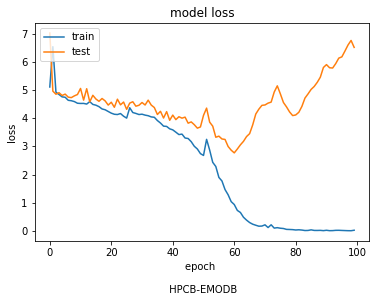

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch \n \n HPCB-EMODB')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [31]:
plt.plot(history.history['dense_3_accuracy'])
plt.plot(history.history['val_dense_3_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch \n \n HPCB-EMODB')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

KeyError: 'dense_3_accuracy'

In [ ]:
plt.plot(history.history['dense_4_accuracy'])
plt.plot(history.history['val_dense_4_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch \n \n HPCB-EMODB')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
plt.plot(history.history['dense_5_accuracy'])
plt.plot(history.history['val_dense_5_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch \n \n HPCB-EMODB')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
labele=['A','B','D','F','H','N', 'S']
tick_marks = np.array(range(len(labele))) + 0.5

def plot_confusion_matrix(cm, target_names, title='HMN-EMODB', normalize=True):
    rows,cols=cm.shape
    p,r=np.arange(rows),np.arange(cols)
    for m in range(rows):
        p[m]=cm[m][m]
    p,r=p/cm.sum(axis=0),p/cm.sum(axis=1)
    pa,ra=p.sum()/len(p),r.sum()/len(r)
    #print(cm)            
    #print(p,r)
    #print(format(pa*100, '.2f'),format(ra*100, '.2f'))
    precision=pa*100
    recall=ra*100
    F1_score=2*precision*recall/(precision+recall)
    
    acc= np.trace(cm) / float(np.sum(cm)) #计算准确率
    accuracy=acc*100   
    plt.figure(figsize=(10,8)) 

    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.OrRd)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(target_names)))
    plt.xticks(xlocations, target_names, color='black', fontsize=12)
    plt.yticks(xlocations, target_names, color='black', fontsize=12)
    plt.ylabel('True class (%)', fontsize=12)
    plt.xlabel('Predicted class (%)\n  \n accuracy={:0.2f}, precision={:0.2f}, recall={:0.2f}, F1_score={:0.2f}'.format(accuracy, precision, recall, F1_score), fontsize=12)   
    ind_array = np.arange(len(target_names))
    cm, cm = np.meshgrid(ind_array, ind_array)

    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        c = cm_normalized[j][i]
        plt.text(i, j, "%0.2f" % (c*100,), color='black', fontsize=12, va='center', ha='center')    
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.savefig(title+'.jpg', dpi = 300)
    plt.show()

In [ ]:
def plot_confuse(model, x_val, y_val):
    predictions = model.predict(x_val) #输入测试集，输出预测结果
    predictions=np.argmax(predictions,axis=1)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    print(conf_mat)
    plt.figure()
    plot_confusion_matrix(conf_mat, normalize=False,target_names=labele,title='HPCB-EMODB-Train')

In [ ]:
plot_confuse(model, data_val, labels_val)

In [ ]:
def plot_confuse(model, x_val, y_val):
    predictions = model.predict(x_val) #输入测试集，输出预测结果
    predictions=np.argmax(predictions,axis=1)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, normalize=False,target_names=labele,title='HPCB-EMODB-Data')

In [ ]:
def plot_confuse(model, x_val, y_val):
    predictions = model.predict(x_val) #输入测试集，输出预测结果
    predictions = np.argmax(predictions, axis = 1)
    truelabel = y_val.argmax(axis = -1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true = truelabel, y_pred = predictions)
    plt.figure() 
    plot_confusion_matrix(conf_mat, normalize = False, target_names = labele, title = 'HPCB-EMODB-Test')